
# שיעור 10 - RS based FAO
<p dir="rtl" style="text-align: right;">
המשך שיטות להערכת אידוי דיות.
<p dir="rtl" style="text-align: right;">
השבוע נדבר על שיטה אמפירית שמבוססת על ארגון המזון והחקלאות של ארה"ב.:
<p dir="rtl" style="text-align: right;">
השיטה מתייחסת לאידוי דיות ממשטח ידוע בתנאי אקלים ידועים. אם נרצה את האידוי דיות (א"ד) מגידול אחר צריך לכפול בגורם גידול. אנחנו מתייחסים למצב שאין מגבלת מים.  על מנת להתייחס למצב של מגבלת מים צריך להכפיל את גורם הגידול בעוד פקטור שלוקח בחשבון את זמינות המים. גורם הגידול משתנה במהלך העונה. 

<p dir="rtl" style="text-align: right;">
אם רוצים להתייחס גם לאידוי מפני הקרקע אז צריך להכניס גם את הגורם הזה לKc . הגורם של הקרקע נקרא ke. זו השיטה שמשמשת להשקיה כיום. גורם הגידול משתנה בעונ: יש גורם בהתחלה, אמצע וסוף. 
גורם הגידול שווה ליחס בין ההתאדות מאותו גידול (ללא מחסור מים) לבין ההתאדות ממשטח הדשא באותו גודל ללא חוסר במים. 

<p dir="rtl" style="text-align: right;">
גורם הגידול בתנאי אקלים סטנדרטיים מותאם בפונקציה לתנאים האמיתיים (כתלות למהירות רוח , לחות ווגובה הגידול). המהלך הפנולוגי של גורם הגידול הוא ביחס מסוים למדדי צומח שאחנו מכירים (כמו ndvi). 

<p dir="rtl" style="text-align: right;">
יש דרך לחשב את האידוי (ללא מחסור מים) עבור גידול ספציפי כתלות בndvi . צריך להתחשב גם בקרקע וגם בצומח ולהתאים את ndvi לkc ו ke. משתמשים ביחס של כמות המים שהגיע למערכת ביחס לאידוי הפוטנציאלי המקסימלי. בכל יום משתמשים ביחס הזה עבור הx ימים הקודמים. כופלים את kc שמתקבל בעזרת ndvi בפקטור הזה של המים ואז kc מותאם למצב המים...

<p dir="rtl" style="text-align: right;">
אפשר להגיע מזה גם למאזן המים בקרקע וללחות הקרקע. מורידים מכמות המים שנכנסה את מה שנצרך בא"ד ואת הנגר והחלחול מתחת בית השורשים. השיעור המשיך בהסבר מה המודלים שמשמשים לצורך זה. 


</p>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# 1_import_packages
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import statsmodels.api as sm
import numpy  as np
import os
import datetime
import pandas as pd
import warnings
import ee
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
  
# 2_Authenticate_GEE_account
!earthengine authenticate

Instructions for updating:
non-resource variables are not supported in the long term
To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=1PYVZXnFPfXFKiGabKbe8HNpBff_Nd7coNDG_1mR9Zw&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g6wiKSqHZrxVF6Z8XD_4DtTUlvfWnq4jyTYx49NtWd4FTFDeY9KTTI

Successfully saved authorization token.


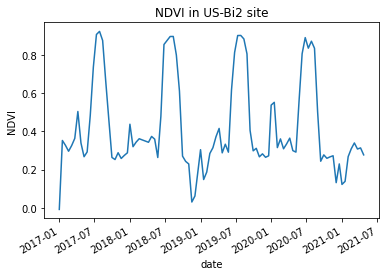

In [ ]:
  
# 3_Get_NDVI_ts_from_GEE_for_lat_lon

ee.Initialize()
# donwload NDVI for our site https://ameriflux.lbl.gov/sites/siteinfo/US-Bi2#overview 
# This is the lat/lon of the Fluxnet site (US-Bi2)
poi  = ee.Geometry.Point(-121.5351, 38.1091)

# We will get NDVI time series for this site from 1/1/2017 to 1/5/2021
NDVI = ee.ImageCollection("MODIS/006/MOD13Q1").filterDate('2017-01-01','2021-05-01')

# This is how we get it from an image collection using GEE API:
def poi_mean(img):
    mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=poi, scale=250).get('NDVI')
    return img.set('date', img.date().format()).set('mean',mean)
poi_reduced_imgs = NDVI.map(poi_mean)
nested_list = poi_reduced_imgs.reduceColumns(ee.Reducer.toList(2), ['date','mean']).values().get(0)
df_ndvi     = pd.DataFrame(nested_list.getInfo(), columns=['date','mean'])

df_ndvi["NDVI"] = df_ndvi["mean"] * 0.0001 # !!Remember: there's a scale factor to apply!!
df_ndvi['date'] = pd.to_datetime(df_ndvi['date'])
df_ndvi.set_index('date', inplace=True)

# Display the NDVI time series for this site (notice: it's a 16-day ts and we
# need daily data...)
df_ndvi["NDVI"].plot(ylabel='NDVI',title='NDVI in US-Bi2 site')
NDVI_=df_ndvi["NDVI"].tolist()

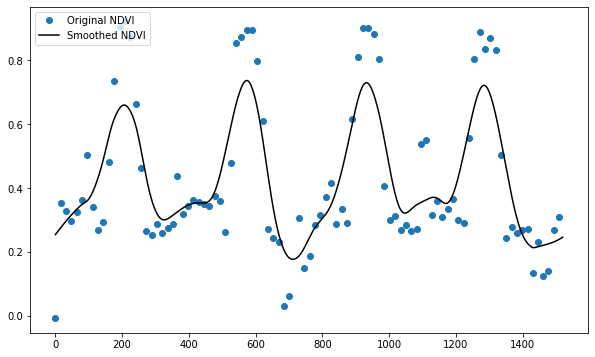

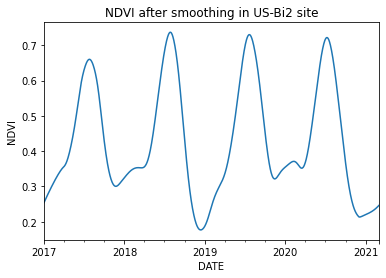

In [ ]:
# 4_Interpolate_to_daily_and_apply_smoothing_LOESS

idx              = pd.date_range('01-01-2017', '03-01-2021') # First is month then day
df_ndvi['index'] = df_ndvi.index
df_ndvi          = df_ndvi.reindex(idx)
df_int           = df_ndvi.reindex(idx)
df_loess         = df_ndvi.reindex(idx)

# We want to expand the vector from having data every 16 days to having daily data
n = len(df_ndvi)
x = list(range(0,n))

original_y  = df_ndvi['NDVI'].tolist()
original_x  = df_ndvi['index'].tolist()

# We will use linear interpolation for that..
df_int['NDVI'] =  df_int['NDVI'].interpolate('linear')
y = df_int['NDVI'].tolist()
x = df_int['index'].tolist()
x = list(range(0,n))

# Now, let's apply the LOESS smoothing technique to get rid of noisy data
lowess = sm.nonparametric.lowess(y, x, frac=.12)
lowess_x = list(zip(*lowess))[0]
lowess_y = list(zip(*lowess))[1]
df_loess['NDVI'] = lowess_y

# Display both, original and smoothed ts:
plt.figure(figsize=(10, 6))    
plt.plot(x, original_y, 'o',label="Original NDVI")#
plt.plot(x, lowess_y, '-k',label="Smoothed NDVI")#
plt.legend(loc="upper left")
plt.figure()

# Display smoothed NDVI with real dates
df_ndvi['NDVI_after_smoothing'] = lowess_y
df_ndvi['NDVI_after_smoothing'].plot(ylabel='NDVI',xlabel='DATE',title='NDVI after smoothing in US-Bi2 site')

In [ ]:
# 5_Read_meteo_data

# NOTE: You need to upload these two python codes into your working dir first: 
# 'estimate_daily_et.py' and 'evapotranspiration_fao.py'
import evapotranspiration_fao as et

# Let's set the timeframe of our analysis:
start_date = '2017-01-01' # first is month and then day
end_date   = '2021-03-01' 

# Upload your meteo data (from Fluxnet site...)
df_full = pd.read_csv('/content/drive/MyDrive/gdrive_folder/AMF_US-Bi2_BASE_HH_10-5.csv',parse_dates=['DATE'], dayfirst=True)
df_full = df_full.set_index('DATE')
df_full.head()

df = df_full.loc[start_date:end_date]

# Let's see if it read our data...
df

,TIMESTAMP_START,TIMESTAMP_END,CO2,H2O,CH4,FC,FCH4,FC_SSITC_TEST,FCH4_SSITC_TEST,G,H,LE,H_SSITC_TEST,LE_SSITC_TEST,WD,WS,USTAR,ZL,TAU,MO_LENGTH,V_SIGMA,W_SIGMA,TAU_SSITC_TEST_PI_F,PA,RH,TA,VPD_PI,T_SONIC,T_SONIC_SIGMA,TS_PI_1,TS_PI_2,TS_PI_3,TS_PI_4,TS_PI_5,SWC_PI_1,SWC_PI_2,NETRAD,PPFD_IN,PPFD_OUT,SW_IN,SW_OUT,LW_IN,LW_OUT,P,SW_DIF,FC_PI_F,RECO_PI_F,GPP_PI_F,FCH4_PI_F,H_PI_F,LE_PI_F,SPEC_RED_IN,SPEC_RED_OUT,SPEC_NIR_IN,SPEC_NIR_OUT,SPEC_PRI_TGT_IN,SPEC_PRI_TGT_OUT,SPEC_PRI_REF_IN,SPEC_PRI_REF_OUT
DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,2.020000e+11,2.020000e+11,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999,-9999,-9999.000000,-9999.000000,-9999.000000,-9999,-9999,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999,-9999.000,-9999.00,-9999.000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.0,-9999.000000,-9999.0,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.0,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.00000,-9999.00000,-9999.0
2017-01-01 00:30:00,2.020000e+11,2.020000e+11,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999,-9999,-9999.000000,-9999.000000,-9999.000000,-9999,-9999,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999,-9999.000,-9999.00,-9999.000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.0,-9999.000000,-9999.0,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.0,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.00000,-9999.00000,-9999.0
2017-01-01 01:00:00,2.020000e+11,2.020000e+11,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999,-9999,-9999.000000,-9999.000000,-9999.000000,-9999,-9999,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999,-9999.000,-9999.00,-9999.000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.0,-9999.000000,-9999.0,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.0,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.00000,-9999.00000,-9999.0
2017-01-01 01:30:00,2.020000e+11,2.020000e+11,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999,-9999,-9999.000000,-9999.000000,-9999.000000,-9999,-9999,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999,-9999.000,-9999.00,-9999.000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.0,-9999.000000,-9999.0,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.0,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.00000,-9999.00000,-9999.0
2017-01-01 02:00:00,2.020000e+11,2.020000e+11,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999,-9999,-9999.000000,-9999.000000,-9999.000000,-9999,-9999,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999,-9999.000,-9999.00,-9999.000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.0,-9999.000000,-9999.0,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.0,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.0,-9999.0,-9999.0,-9999.

LE
NETRAD
TA
WS
PA
RH


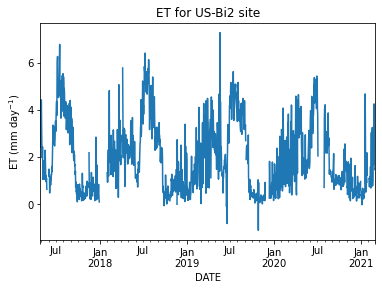

In [ ]:
# 6_Convert_data_units_and_calculate_mean_values

# We need only some of the variables: LE, net radiation, average temperature, wind speed
# atmospheric pressure, and relative humidity

#https://ameriflux.lbl.gov/sites/siteinfo/US-Bi2#overview
list_of_column = ['LE','NETRAD','TA','WS','PA','RH']
df             = df[['LE','NETRAD','TA','WS','PA','RH']]

# Let's drop dates with nan (-9999 in the csv file):
for column in list_of_column:
    print (column)
    index_names = df[ df[column] == -9999 ].index
    df.drop(index_names, inplace = True)

# We need to convert Rn from W m-2 to MJ m-2 day-1
df['NETRAD_daily'] = df['NETRAD'] * 3600 * 24 / 1000000 

# We need to get max and min Temp. (all other variables are mean values)
d_TA_MIN        = df['TA'].resample('D').min()
d_TA_MAX        = df['TA'].resample('D').max()

# Calculate daily mean values for all variables
df = df.resample('D').mean() 

# Save the new data
#df['NETRAD_daily'] = df_NETRAD_daily.tolist()
df['TA_MIN']       = d_TA_MIN.tolist()
df['TA_MAX']       = d_TA_MAX.tolist()

# We also need to convert LE to ET from W m-2 to mm day-1
# the conversion factor is: 1 W m-2 = 28.94 mm day-1 (dependes on Tavg)
df['ET']           = df['LE'] / 28.94 

# Display daily ET:
df['ET'].plot(ylabel = 'ET (mm day$^{-1}$)',xlabel='DATE',title='ET for US-Bi2 site')

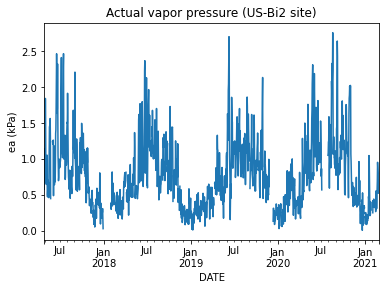

In [ ]:
# 7_Calculate_variables_for_ET0

# Calculate saturation vapor pressure from Tavg and RH:
df['es'] = df['TA'].apply(et.Saturation_vapor_pressure)

# Now, let's use es to calculate the actual vapour pressure (ea)
df['ea'] = ( (1 - (df['RH']) / 100) ) * df['es']

# Display the actual vapor pressure:
df['ea'].plot(ylabel='ea (kPa)',xlabel='DATE',title='Actual vapor pressure (US-Bi2 site)')

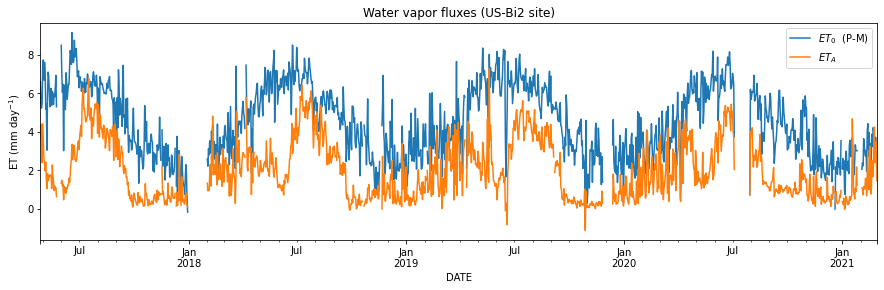

In [ ]:
# 8_Calculate_ET0_using_Penman_Monteith

df['fao_reference_et'] = df[['NETRAD_daily','TA','WS','ea','PA']].apply(
    lambda row: et.fao_reference_et(row['NETRAD_daily'],
                                    row['TA'],row['WS'],
                                    row['ea'],row['PA']) , axis=1)

# Display both, ET0 and actual ET
df['fao_reference_et'].plot(figsize=(15,4), 
                            ylabel='ET fluxes (mm day$^{-1}$)',xlabel='DATE',
                            title='Water vapor fluxes (US-Bi2 site)', 
                            label="$ET_{0}$  (P-M)")
df['ET'].plot(ylabel = 'ET (mm day$^{-1}$)', label="$ET_{A}$")
plt.legend(loc="upper right")

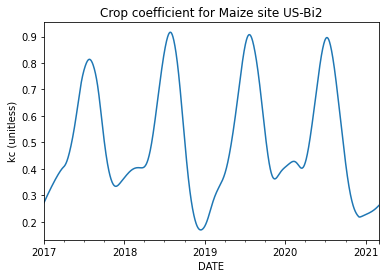

In [ ]:
# 9a_Derive_kc_from_NDVI

# We need to relate our flux data to the NDVI data in terms of dates
filtered_NDVI = df_loess.loc[start_date:end_date]
filtered_df   = df.loc[start_date:end_date]

data          = pd.merge(filtered_NDVI, filtered_df, left_index=True, right_index=True, how='outer')

# Delete the unnecessary rows from NDVI data:
data.drop('mean' , inplace=True, axis=1)  
data.drop('index', inplace=True, axis=1)

#function FOR  FVC
NDVImin = 0.05
NDVImax = 0.95
def FVC(NDVI):
     FVC_V = (NDVI - NDVImin) / (NDVImax - NDVImin)
     if FVC_V > 1:
       FVC_V = 1.0
     if FVC_V < 0.0:
       FVC_V = 0.0
     return FVC_V

data['fvc'] = data['NDVI'].apply(FVC)  

# We'll use the maximum value of kc for maize from a lookup table to constrain 
# our kc:
Kc_max = 1.2
data['kc'] = data['fvc'] * Kc_max

# Let's display kc:
data['kc'].plot(ylabel='kc (unitless)', xlabel='DATE',title='Crop coefficient for Maize site US-Bi2')

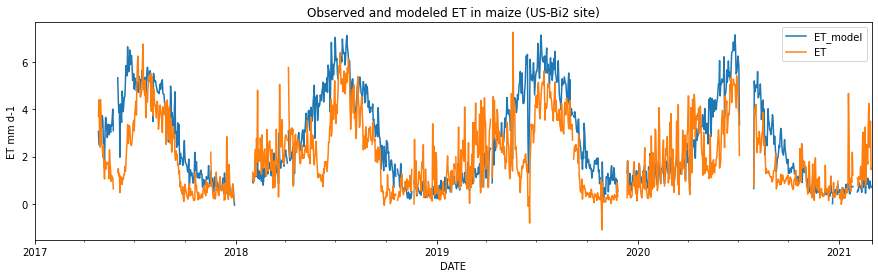

In [ ]:
# 9b_Calculate_FAO56_ET_and_display

# Calculate actual ET [mm d-1] using FAO56 with NDVI:
data['ET_model'] = data[['kc','fao_reference_et']].apply(
    lambda row: et.actual_evapotranspiration(row['kc'], row['fao_reference_et']) , axis=1)

# Display modeled and observed ET
data[['ET_model', 'ET']].plot(figsize=(15,4),ylabel='ET mm d-1',xlabel='DATE',title='Observed and modeled ET in maize (US-Bi2 site)')

Statistics:
MAE:  1.06 mm day-1
RMSE: 1.41 mm day-1
Bias: 0.61 mm day-1
R-Squared: 0.54
P-value: 0.0000




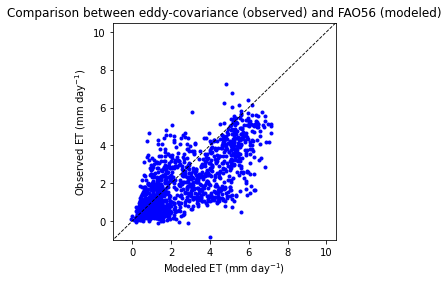

In [ ]:
# 9c_Scatterplot_of_obs_vs_mod

import scipy
import sklearn.metrics as metrics
# Remember that MOD11A1 is an LST product at 10:30 and MYD11A1 is LST at 13:30
x1 = data["ET_model"].values
y1 = data["ET"].values

# Use only pixels in both arrays that are not nan
mask = ~np.isnan(x1) & ~np.isnan(y1)

# mask nan in both arrays
x = x1[mask]
y = y1[mask]

# calculate statistics
mae  = metrics.mean_absolute_error(x, y)
mse  = metrics.mean_squared_error(x, y)
rmse = np.sqrt(mse)

delta_et = x-y
bias = delta_et.sum()/len(delta_et)

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)

# Print statistics
print("Statistics:")
print("MAE:  {:.2f}".format(mae),'mm day-1')
print("RMSE: {:.2f}".format(rmse),'mm day-1')
print("Bias: {:.2f}".format(bias),'mm day-1')
print("R-Squared: {:.2f}".format(r_value**2))
print("P-value: {:.4f}".format(p_value))
print('')
print('')

plt.figure(1,figsize=(4,4)).clf()
s = plt.scatter(x1, y1, marker='.', color='blue') 
plt.xlabel('Modeled ET (mm day$^{-1}$)')
plt.ylabel('Observed ET (mm day$^{-1}$)')
plt.title('Comparison between eddy-covariance (observed) and FAO56 (modeled)') 
plt.xlim([-1, 10.5])
plt.ylim([-1, 10.5])

# draw a 1:1 line:
plt.plot([-10, 40], [-10, 40], 'k--', linewidth=0.9)